### Resource-Task Network (RTN)

#### Resource Balance:
$$ X_{r,t} = X_{r,t-1} + \sum_{i \in I_r} \sum_{\theta = 0}^{\tau_i} (\mu_{i,r,\theta} \cdot N_{i,t-\theta} + \nu_{i,r,\theta} \cdot \xi_{i,t-\theta}) + \Pi_{r,t} \quad \forall r \in R, t \in T$$
#### Resource Limits:
$$ X_{r}^{min} \le X_{r,t} \le X_{r}^{max} \quad \forall r \in R, t \in T$$
#### Batch Limits:
$$ V_{i}^{min} \cdot N_{i,t} \le \xi_{i,t} \le V_{i}^{max} \cdot N_{i,t} \quad \forall i \in I, t \in T$$

### System Being Modeled

#### Reaction Pathways:
1 reactor can perform three different stoichiomentric reactions (50/50 ratio for reactants):
- Reaction 1: $$ A + B \rightarrow D $$
- Reaction 2: $$ A + C \rightarrow E $$
- Reaction 3: $$ B + C \rightarrow F $$

#### Equipment:
- Storage Tanks: each material has a dedicated storage tank with a 100 L capacity.
- Reactor: The reactor can be used to produce batches that are between 30 and 60 L.

#### External material flow:
- Raw material supply arrives at t = 6, 7, 8, 9, and 10 (10 units arrive in each time period)
- External demand of products D, E, and F occurs at t = 6, 7, 8, 9, and 10 (10 units are consumed in each period0).

#### Objective:
Find the production schedule that will satisfy the external demands and require the least number of batches.

### Define the Network using NetworkX

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

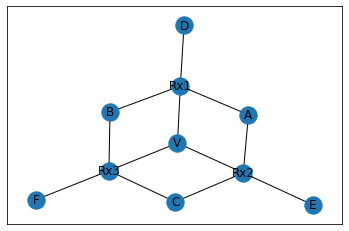

In [3]:
net = nx.Graph() #create network
nodes = ["A","B","C","D","E","F","V","Rx1","Rx2","Rx3"] #node labels
R = ["A","B","C","D","E","F","V"] #resource nodes
Rreact = ["A","B","C"] #reactants
Rprod = ["D","E","F"] #products
I = ["Rx1","Rx2","Rx3"] #task nodes

#create nodes
for n in nodes:
    if n in I:
        net.add_node(n, tau = 1, Vmin = 30, Vmax = 60) #tau = processing time, Vmin = minimum batch size for each task, Vmax = maximum batch size for each task
    elif n in Rreact:
        net.add_node(n, X0 = 100, Xmin = 0, Xmax = 100) #X0 = initial inventory (full reactant tanks), Xmin = minimum resource level (safety stock), Xmax = resource capacity
    elif n in Rprod:
        net.add_node(n, X0 = 0, Xmin = 0, Xmax = 100) #X0 = initial inventory (empty tanks), Xmin = minimum resource level (safety stock), Xmax = resource capacity
    elif n == "V":
        net.add_node(n, X0 = 1, Xmin = 0, Xmax = 1) #X0 = number of reactors available initially, Xmin = minimum number of available reactors (busy reactor = 0 available), Xmax = number of reactors

#connect network
net.add_edges_from([
    ("A","Rx1"),
    ("B","Rx1"),
    ("D","Rx1"),

    ("A","Rx2"),
    ("C","Rx2"),
    ("E","Rx2"),
    
    ("B","Rx3"),
    ("C","Rx3"),
    ("F","Rx3"),

    ("V","Rx1"),
    ("V","Rx2"),
    ("V","Rx3"),
])

#add metadata to the edges
#mu is the fixed consumption/production ratio
#nu is the variable consumption/production ratio
for e in net.edges:
    if e[0] in Rreact:
        net.edges[e]["mu"] = {theta: 0 for theta in range(net.nodes[e[1]]["tau"] + 1)} #reactant consumption depends on batch size, not on task execution
        net.edges[e]["nu"] = {
            theta: -0.5 #50% of the batch size comes from each reactant when task is triggered (theta = 0) (50:50 stoichiometry)
                if theta == 0 else 
                    0 #no other consumption during the reaction duration
            for theta in range(net.nodes[e[1]]["tau"] + 1)
        }
    elif e[0] in Rprod:
        net.edges[e]["mu"] = {theta: 0 for theta in range(net.nodes[e[1]]["tau"] + 1)} #product production depends on batch size, not on task execution
        net.edges[e]["nu"] = {
            theta: 1 #the amount of product is the size of the batch (100% conversion) when theta = tau
                if theta == net.nodes[e[1]]["tau"] else 
                    0 #no amount of product is produced before the reaction ends (no material is drained during task execution)
            for theta in range(net.nodes[e[1]]["tau"] + 1)
        }
    elif e[0] == "V":
        net.edges[e]["mu"] = {
            theta: -1 #when a reaction is triggered (theta = 0), 1 reactor is consumed
                if theta == 0 else 
                    1 #when the reaction completes (theta = tau), 1 reactor is regenerated
                        if theta == net.nodes[e[1]]["tau"] else 
                            0 #no consumption/production of reactors in the intermediate timepoints of the reaction duration
            for theta in range(net.nodes[e[1]]["tau"] + 1)
        }
        net.edges[e]["nu"] = {theta: 0 for theta in range(net.nodes[e[1]]["tau"] + 1)} #consumption/production of reactant not goverened by batch sizes

nx.draw_networkx(net)

### Define the MILP model for the RTN

In [75]:
import pyomo.environ as pe
from pyomo.opt import SolverFactory

In [139]:
horizon = 10
RTN = pe.ConcreteModel()

#define sets
RTN.I = pe.Set(initialize = I) #tasks
RTN.R = pe.Set(initialize = R) #resources
RTN.T = pe.Set(initialize = range(horizon+1)) #time points
RTN.T1 = pe.Set(initialize = range(1,horizon+1)) #exclude time point 0, which is only for initialization
RTN.Ir = pe.Set(RTN.R, initialize = {r: net.neighbors(r) for r in RTN.R}) #tasks associated with each resource r

#define parameters
max_tau = max([net.nodes[i]["tau"] for i in I]) #maximum tau in the system
idx = [(i,r,theta) for i in I for r in R for theta in range(max_tau + 1) if r in net.neighbors(i) and theta <= net.nodes[i]["tau"]] #indices for mu and nu
RTN.idx = pe.Set(dimen=3, initialize = idx) #indices for mu and nu
RTN.mu = pe.Param(RTN.idx, initialize = {idx: net.edges[(idx[0],idx[1])]["mu"][idx[2]] for idx in RTN.idx}) #mu parameter
RTN.nu = pe.Param(RTN.idx, initialize = {idx: net.edges[(idx[0],idx[1])]["nu"][idx[2]] for idx in RTN.idx}) #nu parameter
RTN.tau = pe.Param(RTN.I, initialize = {i: net.nodes[i]["tau"] for i in RTN.I}) #tau (task durations)
RTN.Vmax = pe.Param(RTN.I, initialize = {i: net.nodes[i]["Vmax"] for i in RTN.I}) #Vmax (max batch size)
RTN.Vmin = pe.Param(RTN.I, initialize = {i: net.nodes[i]["Vmin"] for i in RTN.I}) #Vmin (min batch size)
RTN.X0 = pe.Param(RTN.R, initialize = {r: net.nodes[r]["X0"] for r in RTN.R}) #X0 (initial resource inventory)
RTN.Xmax = pe.Param(RTN.R, initialize = {r: net.nodes[r]["Xmax"] for r in RTN.R}) #Xmax (maximum resource inventory)
RTN.Xmin = pe.Param(RTN.R, initialize = {r: net.nodes[r]["Xmin"] for r in RTN.R}) #Xmin (minimum resource inventory)
RTN.Pi = pe.Param(RTN.R, RTN.T1, initialize = { #Pi (external entrance/exit)
    (r,t): -10 #the demand (exit) for products is 50 units at t = horizon
        if r in Rprod and t > horizon/2 else
            10 if r in Rreact and t > horizon/2 else #receive (entrance) 10 units of raw materials for the second half of the timeline
                0
    for r in RTN.R for t in RTN.T1
    }
) 

#variables
RTN.X = pe.Var(RTN.R, RTN.T, domain=pe.NonNegativeReals) #resource inventory level
for r in RTN.R:
    RTN.X[r,0].fix(RTN.X0[r]) #set initial inventory levels
RTN.N = pe.Var(RTN.I, RTN.T1, domain=pe.Binary) #task triggering
RTN.E = pe.Var(RTN.I, RTN.T1, domain=pe.NonNegativeReals) #task batch size

#constraints
RTN.Balance = pe.ConstraintList()
RTN.ResourceLB = pe.ConstraintList()
RTN.ResourceUB = pe.ConstraintList()
RTN.BatchLB = pe.ConstraintList()
RTN.BatchUB = pe.ConstraintList()

for t in RTN.T1:
    for r in RTN.R:
        RTN.Balance.add(
            RTN.X[r,t] == 
                RTN.X[r,t-1]
                + sum(
                    RTN.mu[i,r,theta] * RTN.N[i,t-theta] 
                    + RTN.nu[i,r,theta] * RTN.E[i,t-theta] 
                    for i in RTN.Ir[r] 
                    for theta in range(max_tau + 1) if theta <= RTN.tau[i] and t-theta >= 1
                )
                + RTN.Pi[r,t]
        )

        RTN.ResourceLB.add(
            RTN.Xmin[r] <= RTN.X[r,t]
        )

        RTN.ResourceUB.add(
            RTN.X[r,t] <= RTN.Xmax[r]
        )

    for i in RTN.I:
        RTN.BatchLB.add(
            RTN.Vmin[i] * RTN.N[i,t] <= RTN.E[i,t]
        )

        RTN.BatchUB.add(
            RTN.E[i,t] <= RTN.Vmax[i] * RTN.N[i,t]
        )

#objective
RTN.obj = pe.Objective(
    expr = sum(RTN.N[i,t] for i in RTN.I for t in RTN.T1),
    sense = pe.minimize
)

#solve
res = SolverFactory('glpk').solve(RTN)
print(res)


Problem: 
- Name: unknown
  Lower bound: 3.0
  Upper bound: 3.0
  Number of objectives: 1
  Number of constraints: 271
  Number of variables: 131
  Number of nonzeros: 538
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 33
      Number of created subproblems: 33
  Error rc: 0
  Time: 0.011601686477661133
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



### Plot the results

In [145]:
import pandas as pd
X = RTN.X.get_values() #get resource levels
E = RTN.E.get_values() #get batch sizes
resources = pd.DataFrame(columns = R, data = {r: [X[r,t] for t in RTN.T] for r in R})
tanks = resources.iloc[:,0:5]
reactor = resources.loc[:,"V"]
batches = pd.DataFrame(columns = I, data = {i: [E[i,t] for t in RTN.T1] for i in I})

<AxesSubplot:title={'center':'material tanks'}, xlabel='time', ylabel='inventory level'>

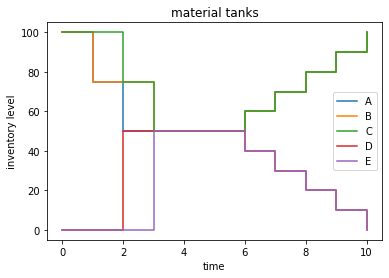

In [146]:
tanks.plot(title="material tanks",xlabel="time",ylabel="inventory level",drawstyle="steps-post")

### Observations:
The system builds inventory in the first three time periods so that it has enough to meet the demand in the last 4 periods.

<AxesSubplot:title={'center':'reactor'}, xlabel='time', ylabel='availability'>

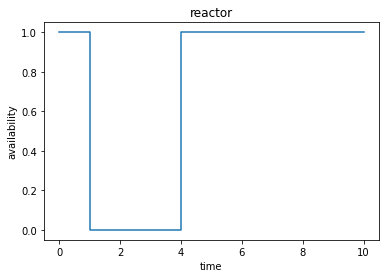

In [147]:
reactor.plot(title="reactor",xlabel="time",ylabel="availability",drawstyle="steps-post")

<AxesSubplot:title={'center':'batches'}, xlabel='time', ylabel='size'>

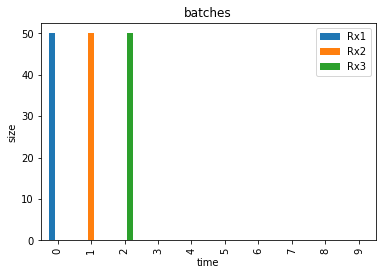

In [151]:
batches.plot(kind="bar",title="batches",xlabel="time",ylabel="size")

### Observations:
The reactor is used three times at t = 1, 2, 3. Since the objective penalizes for the number of times a reaction is triggered, the reactor is used only once for each material since its production capacity allows it.